# Statistical analysis 

<p>- Here we explore the data and create the parameters for it to be valid and have the required featores for the desired output-</p>

In [1]:
from __future__ import print_function, division

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras import Sequential
from sklearn.metrics import roc_auc_score

os.environ["KERAS_BACKEND"] = "tensorflow"


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [5]:
print('Loading word vectors...', end='\r')
word2vec = {}
with open(os.path.join(f'../large_files/glove.6B/glove.6B.{EMBEDDING_DIM}d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
print(f'Found {len(word2vec)} word vectors', end='\n')

Found 400000 word vectors


In [6]:
print('Loading in comments...', end='\r')

train = pd.read_csv("../large_files/toxic_comments/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

sequences_length = [len(s) for s in sentences]
print(f'Max sequence lenght: {max(sequences_length)}', end='\n')
print(f'Min sequence lenght: {min(sequences_length)}', end='\n')
sequences_length = sorted(sequences_length)
print(f'Median sequence lenght: {sequences_length[len(sequences_length) // 2]}', end='\n')


Max sequence lenght: 5000
Min sequence lenght: 6
Median sequence lenght: 205


In [7]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [8]:
word2dix = tokenizer.word_index
print(f'Found {len(word2dix)} unique tokens')

Found 210337 unique tokens


In [9]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(f'Size of data tensor: {data.shape}')

Size of data tensor: (159571, 100)


In [10]:
print('Filling pre-trained emmbeddings...', end='\r')
num_words = min(MAX_VOCAB_SIZE, len(word2dix) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2dix.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model Building and configuration
<p>Here we create the model using the embedding, convolutional and fully connected layers</p>
<ol>
    <li><p>Embedding layer</br><span>Here we configure num_words, EMBEDDING_DIM, weights, input_length, and define if it's trainable</span></p></li>    
</ol>

In [11]:
print('Building model...', end='\r')

embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    trainable=False,
)

embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential(
    [
        embedding_layer,
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(3),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(3),
        Conv1D(128, 3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dense(len(possible_labels), activation='sigmoid')
    ]
)

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         4

In [12]:
print('Training model...', end='\r')
tf.debugging.set_log_device_placement(False)
history = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Epoch 1/10odel...
998/998 [==============================] - 10s 5ms/step - loss: 0.0844 - accuracy: 0.9805 - val_loss: 0.0702 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0679 - accuracy: 0.9926 - val_loss: 0.0696 - val_accuracy: 0.9918
Epoch 3/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0632 - accuracy: 0.9921 - val_loss: 0.0694 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0598 - accuracy: 0.9930 - val_loss: 0.0723 - val_accuracy: 0.9937
Epoch 5/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0574 - accuracy: 0.9931 - val_loss: 0.0827 - val_accuracy: 0.9924
Epoch 6/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0551 - accuracy: 0.9934 - val_loss: 0.0843 - val_accuracy: 0.9934
Epoch 7/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0535 - accuracy: 0.9936 - val_loss: 0.0782 - val_accuracy: 0.992

# Plot model accuracy and results

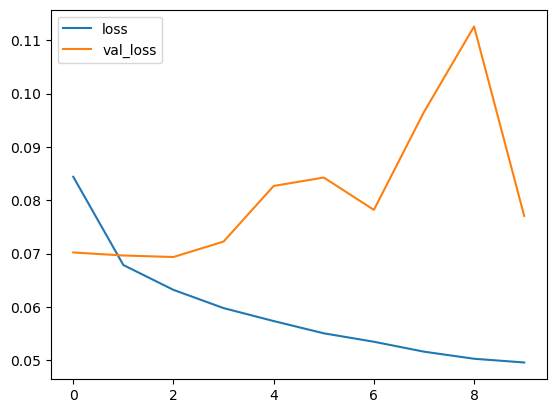

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

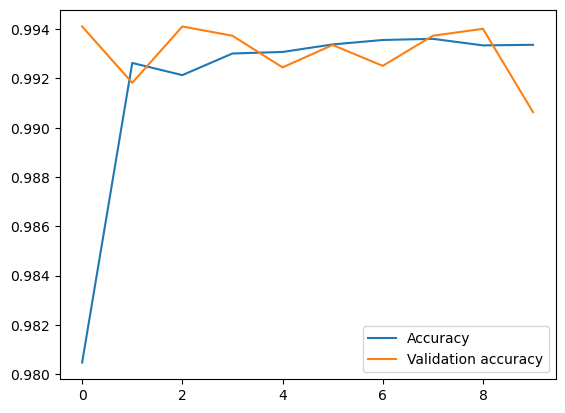

In [15]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

In [17]:
p = model.predict(data)
aucs = []
for j  in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

4987/4987 [==============================] - 7s 1ms/step
0.9735911528385405
